# Train and test a NER model using the GMB Dataset

### 1. Load Dependencies

In [183]:
import os
import collections

#Data analysis
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
import eli5
import tensorflow as tf
import keras as K
from keras.regularizers import l2
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_contrib.layers import CRF
from keras.utils import to_categorical
from keras import optimizers
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

#Optimize
import GPy, GPyOpt

### 2. Load Data

In [137]:
# Credit: https://nlpforhackers.io/named-entity-extraction/
def to_conll_iob(sentence):
    """
    Take an annotated sentence, and convert to proper CONLL format
    [O, PERSON, PERSON, O, O, LOCATION, O] --> [O, B-PERSON, I-PERSON, O, O, B-LOCATION, O]
    """
    conll_iob_tokens = []
    for idx, tok in enumerate(sentence):
        tag, word, ner = tok
        if ner != 'O':
            if idx == 0:
                ner = "B-" + ner
            elif sentence[idx - 1][2] == ner:
                ner = "I-" + ner
            else:
                ner = "B-" + ner
        conll_iob_tokens.append((tag, word, ner))
    return conll_iob_tokens

ner_tags = collections.Counter()
corpus_root = "./gmb-2.2.0"

def read_gmb(corpus_root):
    """
    load the data convert to usable format ([w1, pos1, tag1]...[wn, posn, tagn])
    """
    conll_tokens = [] # final clean data
    for root, dirs, files in os.walk(corpus_root):
        for filename in files: #all folders
            if filename.endswith(".tags"): #all files in folder with .tags
                with open(os.path.join(root, filename), 'rb') as inf:
                    info = inf.read().decode('utf-8').strip()
                    sentences = info.split('\n\n')   # Split sentences
                    for sentence in sentences:
                        toks = [seq for seq in sentence.split('\n') if seq]  # Split words
                        orig_toks = []
                        for idx, tok in enumerate(toks):
                            annotations = tok.split('\t')
                            word, tag, ner = annotations[0], annotations[1], annotations[3]
                            ner_tags[ner] += 1
                            if ner != 'O':
                                ner = ner.split('-')[0]
                            if tag in ('LQU', 'RQU'):
                                tag = "``"
                            orig_toks.append((word, tag, ner))
                        conll_tokens.append(to_conll_iob(orig_toks))
    return conll_tokens

sentences = read_gmb(corpus_root)

In [134]:
# sneak peak into converted data
sentences[0]

[('Masked', 'VBN', 'O'),
 ('assailants', 'NNS', 'O'),
 ('with', 'IN', 'O'),
 ('grenades', 'NNS', 'O'),
 ('and', 'CC', 'O'),
 ('automatic', 'JJ', 'O'),
 ('weapons', 'NNS', 'O'),
 ('attacked', 'VBD', 'O'),
 ('a', 'DT', 'O'),
 ('wedding', 'VBG', 'O'),
 ('party', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('southeastern', 'JJ', 'O'),
 ('Turkey', 'NNP', 'B-geo'),
 (',', ',', 'O'),
 ('killing', 'VBG', 'O'),
 ('45', 'CD', 'O'),
 ('people', 'NNS', 'O'),
 ('and', 'CC', 'O'),
 ('wounding', 'VBG', 'O'),
 ('at', 'IN', 'O'),
 ('least', 'JJS', 'O'),
 ('six', 'CD', 'O'),
 ('others', 'NNS', 'O'),
 ('.', '.', 'O')]

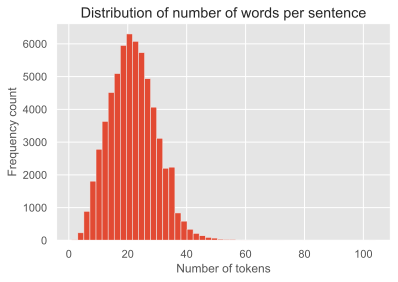

In [7]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Distribution of number of words per sentence')
plt.ylabel('Frequency count')
plt.xlabel('Number of tokens')
plt.show()

In [135]:
#Longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Max length of sentence in corpus:', maxlen)

Max length of sentence in corpus: 104


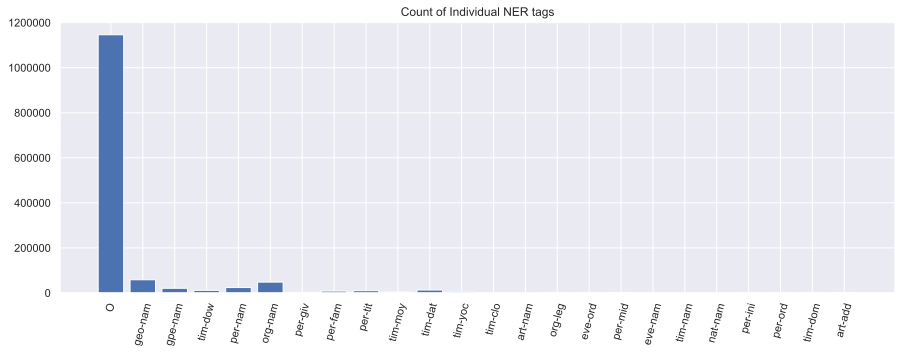

In [139]:
plt.figure(figsize=(15, 5))
plt.title('Count of Individual NER tags')
plt.bar(range(len(ner_tags)), list(ner_tags.values()), align='center')
plt.xticks(range(len(ner_tags)), list(ner_tags.keys()), rotation=75)
plt.show()

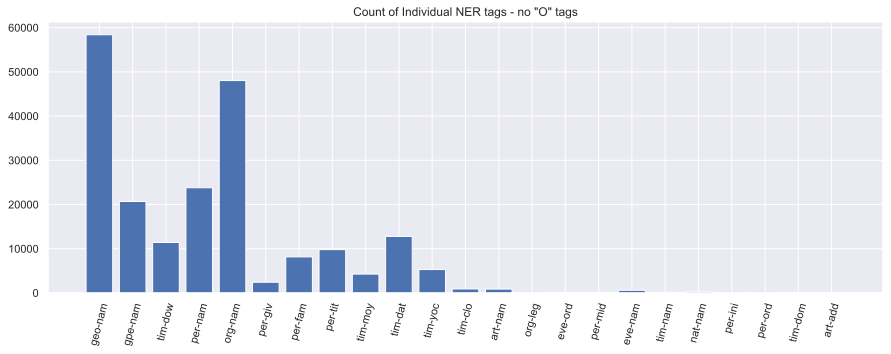

In [140]:
# remove "O" tag
ner_tags.pop("O", None)
plt.figure(figsize=(15, 5))
plt.bar(range(len(ner_tags)), list(ner_tags.values()), align='center')
plt.xticks(range(len(ner_tags)), list(ner_tags.keys()), rotation=75)
plt.title('Count of Individual NER tags - no "O" tags')
plt.show()

### 3. Build Features

In [141]:
# word -> token_index
# The first 2 entries are reserved for PAD and UNK
words = list(set([word_info[0] for tok_info in sentences for word_info in tok_info]))
tags = list(set([word_info[2] for tok_info in sentences for word_info in tok_info]))
pos = list(set([word_info[1] for tok_info in sentences for word_info in tok_info]))

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Label -> tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

pos2idx = {p: i+1 for i, p in enumerate(pos)}
pos2idx['PAD'] = 0

# token_index -> word
idx2word = {i: w for w, i in word2idx.items()}
# tag_index -> Label
idx2tag = {i: w for w, i in tag2idx.items()}
# pos_index -> POS tag
idx2pos = {i:w for w, i in pos2idx.items()}

### 4. Model Building

#### 4.1 Using only words as features

In [178]:
def get_data(use_pos = True, MAX_LEN=60):
    if not use_pos:
        # convert sentences to index's
        X = [[word2idx[w[0]] for w in s] for s in sentences]
        X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

        # Convert outputs to index's
        y = [[tag2idx[w[2]] for w in s] for s in sentences]
        y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

        # One-Hot encode
        n_tags = len(tags)
        y = [to_categorical(i, num_classes=n_tags+1) for i in y]
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25)
    else:
        # convert sentences to index's
        words = [[word2idx[w[0]] for w in s] for s in sentences]
        pad_words = pad_sequences(maxlen=MAX_LEN, sequences=words, padding="post", value=word2idx["PAD"])

        pos = [[pos2idx[w[1]] for w in s] for s in sentences]
        pad_pos = pad_sequences(maxlen=MAX_LEN, sequences=pos, padding="post", value=pos2idx["PAD"])

        #X = np.asarray([np.column_stack((pad_words[i],pad_pos[i])) for i in range(len(pad_words))])
        X = np.column_stack((pad_words,pad_pos))

        # Convert outputs to index's
        y = [[tag2idx[w[2]] for w in s] for s in sentences]
        y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

        # One-Hot encode
        n_tags = len(tags)
        y = [to_categorical(i, num_classes=n_tags+1) for i in y]
        y = np.column_stack((y,y))

        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25)
    print("Shape of data\n")
    print(X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape)
    return X_tr, X_te, y_tr, y_te

In [167]:
# Model save utils
modelFile = './' + 'BiLSTM_CRF.h5'
checkpoint = ModelCheckpoint(filepath=modelFile, monitor='val_crf_viterbi_accuracy', save_best_only = True, mode='auto')
earlyStopping = EarlyStopping(monitor='val_crf_viterbi_accuracy', patience = 4, verbose = 1, mode='auto')

class BiLSTM_CRF():
    def __init__(self, batch_size=128, hidden_units=50, epochs = 20, dropout=0.3, 
                 regularizer=1e-4, max_len=60, embed_dim = 100):

        # tuneable params
        self.batch_size = batch_size
        self.epochs = epochs
        self.hidden_units = hidden_units
        self.dropout = dropout
        self.regilarizer = regularizer
        
        #non-tunable params
        self.max_len = max_len
        self.n_words = n_words
        self.n_tags = n_tags
        self.embed_dim = embed_dim
        
        #data
        self._x_train = X_tr
        self._y_train = np.array(y_tr)
        self._x_test = X_te
        self._y_test = np.array(y_te)
        
        #model
        self.model = self.bilstm_crf()

    def bilstm_crf(self):
        # Model definition
        """
        The Model consists of a Bidirectional LSTM with a CRF layer 
        """
        _input = Input(shape=(self.max_len,))
        # Embedding Layer
        model = Embedding(input_dim=self.n_words+2, output_dim=self.embed_dim,
                          input_length=self.max_len, mask_zero=True)(_input) 
        # LSTM Layer
        model = Bidirectional(LSTM(units=self.hidden_units, 
                                   return_sequences=True,
                                   recurrent_dropout=self.dropout,
                                   kernel_initializer='glorot_normal',
                                   recurrent_initializer='glorot_normal',
                                   bias_initializer='glorot_normal'))(model)
        # Combine
        model = TimeDistributed(Dense(50, 
                                      activation="relu", 
                                      kernel_regularizer=l2(0),
                                      bias_initializer='glorot_normal'))(model)  
        # CRF Layer
        crf = CRF(self.n_tags+1)  # n_tags+1(PAD)
        out = crf(model)  # output
        model = Model(_input, out)
        model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
        return model

    def bilstm_crf_fit(self):
        # fit the model. stop fitting when val accuracy starts dropping.
        early_stopping = EarlyStopping(monitor='val_crf_viterbi_accuracy', patience = 4, mode='max')
        checkpoint = ModelCheckpoint(filepath=modelFile, monitor='val_crf_viterbi_accuracy', save_best_only=True, mode='max')
        history = self.model.fit(self._x_train,
                      self._y_train,
                      shuffle=True,
                      batch_size=self.batch_size,
                      epochs=self.epochs,
                      callbacks=[checkpoint,early_stopping],
                      validation_data=[self._x_test, self._y_test])
        return history

    def bilstm_crf_eval(self):
        # helper to call fit and returns evaluation
        self.bilstm_crf_fit()
        evaluation = self.model.evaluate(self._x_test, self._y_test, batch_size=self.batch_size, verbose=0)
        return evaluation

def run_bilstm_crf(batch_size= 64,
               hidden_units=50,
               epochs=10,
               dropout=0.4,
               regularizer=1e-4, max_len=60):
    _bilstm_crf = BiLSTM_CRF(batch_size=batch_size, 
                         hidden_units=hidden_units, 
                         epochs=epochs,
                         dropout=dropout, 
                         regularizer=regularizer,
                            max_len=max_len)
    bilstm_crf_eval = _bilstm_crf.bilstm_crf_eval()
    return bilstm_crf_eval

In [174]:
X_tr, X_te, y_tr, y_te = get_data(use_pos=False)

# Bayesian Optimization - Tuning following parameters
bounds = [{'name':'batch_size', 'type':'discrete','domain':(32,64,128,512,1048)},
          {'name':'hidden_units', 'type':'discrete','domain':(20,50,80,100)},
          {'name':'epochs', 'type':'discrete','domain':(5,10,15)},
          {'name':'dropout', 'type':'continuous','domain':(0.25,1)},
          {'name':'regularizer', 'type':'continuous','domain':(0.00001, 0.001)}]

# Function I would like to maximize
def f(x):
    print(x)
    evaluation = run_bilstm_crf(batch_size= int(x[:,0]), 
                                hidden_units=int(x[:,1]), 
                                epochs=int(x[:,2]),                    
                                dropout=float(x[:,3]),
                                regularizer=float(x[:,4]), max_len=60)
    print("Train_Loss:\t{0} \t Val_Acc:\t{1}".format(evaluation[0],evaluation[1]))
    print(evaluation)
    return -evaluation[1]

Shape of data

(46507, 60) (15503, 60) (46507, 60, 18) (15503, 60, 18)


In [148]:
# Optimize
opt = GPyOpt.methods.BayesianOptimization(f=f,domain=bounds)

[[3.20000000e+01 1.00000000e+02 1.50000000e+01 9.65451287e-01
  8.41351522e-04]]
Train on 46507 samples, validate on 15503 samples
Epoch 1/15
46507/46507 [==============================] - 224s 5ms/step - loss: 6.8125 - crf_viterbi_accuracy: 0.8978 - val_loss: 6.5723 - val_crf_viterbi_accuracy: 0.9558
Epoch 2/15
46507/46507 [==============================] - 214s 5ms/step - loss: 6.5489 - crf_viterbi_accuracy: 0.9646 - val_loss: 6.5282 - val_crf_viterbi_accuracy: 0.9662
Epoch 3/15
46507/46507 [==============================] - 215s 5ms/step - loss: 6.5182 - crf_viterbi_accuracy: 0.9728 - val_loss: 6.5195 - val_crf_viterbi_accuracy: 0.9677
Epoch 4/15
46507/46507 [==============================] - 213s 5ms/step - loss: 6.5063 - crf_viterbi_accuracy: 0.9759 - val_loss: 6.5159 - val_crf_viterbi_accuracy: 0.9686
Epoch 5/15
46507/46507 [==============================] - 213s 5ms/step - loss: 6.4978 - crf_viterbi_accuracy: 0.9782 - val_loss: 6.5153 - val_crf_viterbi_accuracy: 0.9682
Epoch 6/1

46507/46507 [==============================] - 28s 605us/step - loss: 6.7963 - crf_viterbi_accuracy: 0.8842 - val_loss: 6.7555 - val_crf_viterbi_accuracy: 0.8927
Epoch 4/15
46507/46507 [==============================] - 28s 599us/step - loss: 6.7150 - crf_viterbi_accuracy: 0.9126 - val_loss: 6.6676 - val_crf_viterbi_accuracy: 0.9375
Epoch 5/15
46507/46507 [==============================] - 28s 605us/step - loss: 6.6257 - crf_viterbi_accuracy: 0.9497 - val_loss: 6.6061 - val_crf_viterbi_accuracy: 0.9532
Epoch 6/15
46507/46507 [==============================] - 28s 602us/step - loss: 6.5770 - crf_viterbi_accuracy: 0.9625 - val_loss: 6.5850 - val_crf_viterbi_accuracy: 0.9582
Epoch 7/15
46507/46507 [==============================] - 28s 602us/step - loss: 6.5543 - crf_viterbi_accuracy: 0.9678 - val_loss: 6.5736 - val_crf_viterbi_accuracy: 0.9604
Epoch 8/15
46507/46507 [==============================] - 28s 608us/step - loss: 6.5391 - crf_viterbi_accuracy: 0.9710 - val_loss: 6.5699 - val_cr

In [149]:
opt.run_optimization(max_iter=20)

[[6.4e+01 2.0e+01 5.0e+00 1.0e+00 1.0e-03]]
Train on 46507 samples, validate on 15503 samples
Epoch 1/5
46507/46507 [==============================] - 112s 2ms/step - loss: 6.8156 - crf_viterbi_accuracy: 0.9082 - val_loss: 6.5510 - val_crf_viterbi_accuracy: 0.9639
Epoch 2/5
46507/46507 [==============================] - 105s 2ms/step - loss: 6.5377 - crf_viterbi_accuracy: 0.9702 - val_loss: 6.5295 - val_crf_viterbi_accuracy: 0.9677
Epoch 3/5
46507/46507 [==============================] - 105s 2ms/step - loss: 6.5137 - crf_viterbi_accuracy: 0.9764 - val_loss: 6.5242 - val_crf_viterbi_accuracy: 0.9681
Epoch 4/5
46507/46507 [==============================] - 104s 2ms/step - loss: 6.5017 - crf_viterbi_accuracy: 0.9798 - val_loss: 6.5228 - val_crf_viterbi_accuracy: 0.9677
Epoch 5/5
46507/46507 [==============================] - 105s 2ms/step - loss: 6.4926 - crf_viterbi_accuracy: 0.9825 - val_loss: 6.5252 - val_crf_viterbi_accuracy: 0.9674
Train_Loss:	6.5251689342608765 	 Val_Acc:	0.9673971

46507/46507 [==============================] - 216s 5ms/step - loss: 6.4829 - crf_viterbi_accuracy: 0.9839 - val_loss: 6.5232 - val_crf_viterbi_accuracy: 0.9676
Epoch 8/10
46507/46507 [==============================] - 215s 5ms/step - loss: 6.4787 - crf_viterbi_accuracy: 0.9856 - val_loss: 6.5287 - val_crf_viterbi_accuracy: 0.9673
Epoch 9/10
46507/46507 [==============================] - 660s 14ms/step - loss: 6.4746 - crf_viterbi_accuracy: 0.9876 - val_loss: 6.5322 - val_crf_viterbi_accuracy: 0.9671
Train_Loss:	6.532242050957066 	 Val_Acc:	0.9670746391614483
[6.532242050957066, 0.9670746391614483]
[[6.40000000e+01 5.00000000e+01 1.50000000e+01 6.08691550e-01
  9.09558198e-04]]
Train on 46507 samples, validate on 15503 samples
Epoch 1/15
46507/46507 [==============================] - 593s 13ms/step - loss: 6.7850 - crf_viterbi_accuracy: 0.9131 - val_loss: 6.5533 - val_crf_viterbi_accuracy: 0.9627
Epoch 2/15
46507/46507 [==============================] - 114s 2ms/step - loss: 6.5410 - c

[[6.40000000e+01 2.00000000e+01 1.50000000e+01 2.50000000e-01
  4.31174598e-04]]
Train on 46507 samples, validate on 15503 samples
Epoch 1/15
46507/46507 [==============================] - 122s 3ms/step - loss: 6.8805 - crf_viterbi_accuracy: 0.8768 - val_loss: 6.5790 - val_crf_viterbi_accuracy: 0.9573
Epoch 2/15
46507/46507 [==============================] - 106s 2ms/step - loss: 6.5521 - crf_viterbi_accuracy: 0.9663 - val_loss: 6.5307 - val_crf_viterbi_accuracy: 0.9673
Epoch 3/15
46507/46507 [==============================] - 106s 2ms/step - loss: 6.5187 - crf_viterbi_accuracy: 0.9745 - val_loss: 6.5213 - val_crf_viterbi_accuracy: 0.9686
Epoch 4/15
46507/46507 [==============================] - 108s 2ms/step - loss: 6.5051 - crf_viterbi_accuracy: 0.9779 - val_loss: 6.5193 - val_crf_viterbi_accuracy: 0.9688
Epoch 5/15
46507/46507 [==============================] - 107s 2ms/step - loss: 6.4965 - crf_viterbi_accuracy: 0.9804 - val_loss: 6.5182 - val_crf_viterbi_accuracy: 0.9688
Epoch 6/1

46507/46507 [==============================] - 220s 5ms/step - loss: 6.7479 - crf_viterbi_accuracy: 0.9166 - val_loss: 6.5415 - val_crf_viterbi_accuracy: 0.9640
Epoch 2/5
46507/46507 [==============================] - 201s 4ms/step - loss: 6.5306 - crf_viterbi_accuracy: 0.9700 - val_loss: 6.5192 - val_crf_viterbi_accuracy: 0.9688
Epoch 3/5
46507/46507 [==============================] - 202s 4ms/step - loss: 6.5084 - crf_viterbi_accuracy: 0.9761 - val_loss: 6.5150 - val_crf_viterbi_accuracy: 0.9684
Epoch 4/5
46507/46507 [==============================] - 201s 4ms/step - loss: 6.4973 - crf_viterbi_accuracy: 0.9790 - val_loss: 6.5128 - val_crf_viterbi_accuracy: 0.9684
Epoch 5/5
46507/46507 [==============================] - 207s 4ms/step - loss: 6.4896 - crf_viterbi_accuracy: 0.9817 - val_loss: 6.5143 - val_crf_viterbi_accuracy: 0.9693
Train_Loss:	6.514268628075946 	 Val_Acc:	0.9692964556947229
[6.514268628075946, 0.9692964556947229]
[[3.2e+01 2.0e+01 5.0e+00 2.5e-01 1.0e-05]]
Train on 46

In [150]:
# Best parameter combination -
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
""".format(bounds[0]['name'],opt.x_opt[0],
           bounds[1]['name'],opt.x_opt[1],
           bounds[2]['name'],opt.x_opt[2],
           bounds[3]['name'],opt.x_opt[3],
           bounds[4]['name'],opt.x_opt[4]
          ))
print("Optimized Val Acc:{0}".format(opt.fx_opt))


Optimized Parameters:
	batch_size:	32.0
	hidden_units:	20.0
	epochs:	5.0
	dropout:	0.25
	regularizer:	1e-05

Optimized Val Acc:-0.9692964556947229


#### 4.1 Using words & pos tags as features

In [179]:
# using word+pos tag as features

X_tr, X_te, y_tr, y_te = get_data(use_pos=True)

bounds = [{'name':'batch_size', 'type':'discrete','domain':(32,64,128,512,1048)},
          {'name':'hidden_units', 'type':'discrete','domain':(20,50,80,100)},
          {'name':'epochs', 'type':'discrete','domain':(5,10,15)},
          {'name':'dropout', 'type':'continuous','domain':(0.25,1)},
          {'name':'regularizer', 'type':'continuous','domain':(0.00001, 0.001)}]

def f(x):
    print(x)
    evaluation = run_bilstm_crf(batch_size= int(x[:,0]), 
                                hidden_units=int(x[:,1]), 
                                epochs=int(x[:,2]),                    
                                dropout=float(x[:,3]),
                                regularizer=float(x[:,4]),
                                max_len = 120)
    print("Train_Loss:\t{0} \t Val_Acc:\t{1}".format(evaluation[0],evaluation[1]))
    print(evaluation)
    return -evaluation[1]

Shape of data

(46507, 120) (15503, 120) (46507, 120, 18) (15503, 120, 18)


In [165]:
# optimize
opt = GPyOpt.methods.BayesianOptimization(f=f,domain=bounds)

[[5.12000000e+02 5.00000000e+01 1.50000000e+01 9.34463179e-01
  5.20551102e-04]]
Train on 46507 samples, validate on 15503 samples
Epoch 1/15
46507/46507 [==============================] - 72s 2ms/step - loss: 7.6765 - crf_viterbi_accuracy: 0.7339 - val_loss: 7.1736 - val_crf_viterbi_accuracy: 0.8452
Epoch 2/15
46507/46507 [==============================] - 50s 1ms/step - loss: 6.9466 - crf_viterbi_accuracy: 0.8515 - val_loss: 6.8806 - val_crf_viterbi_accuracy: 0.8703
Epoch 3/15
46507/46507 [==============================] - 48s 1ms/step - loss: 6.8305 - crf_viterbi_accuracy: 0.8773 - val_loss: 6.8159 - val_crf_viterbi_accuracy: 0.8845
Epoch 4/15
46507/46507 [==============================] - 48s 1ms/step - loss: 6.7764 - crf_viterbi_accuracy: 0.8914 - val_loss: 6.7699 - val_crf_viterbi_accuracy: 0.8998
Epoch 5/15
46507/46507 [==============================] - 49s 1ms/step - loss: 6.7306 - crf_viterbi_accuracy: 0.9066 - val_loss: 6.7284 - val_crf_viterbi_accuracy: 0.9131
Epoch 6/15
465

Epoch 9/10
46507/46507 [==============================] - 43s 914us/step - loss: 6.6340 - crf_viterbi_accuracy: 0.9367 - val_loss: 6.6500 - val_crf_viterbi_accuracy: 0.9357
Epoch 10/10
46507/46507 [==============================] - 46s 988us/step - loss: 6.6241 - crf_viterbi_accuracy: 0.9403 - val_loss: 6.6425 - val_crf_viterbi_accuracy: 0.9377
Train_Loss:	6.642467011115416 	 Val_Acc:	0.9377069094946467
[6.642467011115416, 0.9377069094946467]
[[1.04800000e+03 5.00000000e+01 5.00000000e+00 2.95411898e-01
  2.53350140e-04]]
Train on 46507 samples, validate on 15503 samples
Epoch 1/5
46507/46507 [==============================] - 68s 1ms/step - loss: 7.9307 - crf_viterbi_accuracy: 0.6737 - val_loss: 7.2611 - val_crf_viterbi_accuracy: 0.8452
Epoch 2/5
46507/46507 [==============================] - 44s 944us/step - loss: 7.1480 - crf_viterbi_accuracy: 0.8467 - val_loss: 7.0469 - val_crf_viterbi_accuracy: 0.8452
Epoch 3/5
46507/46507 [==============================] - 43s 935us/step - loss: 

In [166]:
opt.run_optimization(max_iter=20)

[[6.40000000e+01 2.00000000e+01 1.00000000e+01 9.10494833e-01
  4.02606081e-04]]
Train on 46507 samples, validate on 15503 samples
Epoch 1/10
46507/46507 [==============================] - 206s 4ms/step - loss: 6.9629 - crf_viterbi_accuracy: 0.8571 - val_loss: 6.7293 - val_crf_viterbi_accuracy: 0.9093
Epoch 2/10
46507/46507 [==============================] - 181s 4ms/step - loss: 6.6562 - crf_viterbi_accuracy: 0.9268 - val_loss: 6.6321 - val_crf_viterbi_accuracy: 0.9376
Epoch 3/10
46507/46507 [==============================] - 178s 4ms/step - loss: 6.6009 - crf_viterbi_accuracy: 0.9436 - val_loss: 6.6127 - val_crf_viterbi_accuracy: 0.9412
Epoch 4/10
46507/46507 [==============================] - 178s 4ms/step - loss: 6.5828 - crf_viterbi_accuracy: 0.9478 - val_loss: 6.6019 - val_crf_viterbi_accuracy: 0.9436
Epoch 5/10
46507/46507 [==============================] - 177s 4ms/step - loss: 6.5729 - crf_viterbi_accuracy: 0.9499 - val_loss: 6.5970 - val_crf_viterbi_accuracy: 0.9441
Epoch 6/1

[[1.28e+02 2.00e+01 1.50e+01 2.50e-01 1.00e-05]]
Train on 46507 samples, validate on 15503 samples
Epoch 1/15
46507/46507 [==============================] - 140s 3ms/step - loss: 7.0639 - crf_viterbi_accuracy: 0.8434 - val_loss: 6.7596 - val_crf_viterbi_accuracy: 0.9017
Epoch 2/15
46507/46507 [==============================] - 106s 2ms/step - loss: 6.6820 - crf_viterbi_accuracy: 0.9220 - val_loss: 6.6466 - val_crf_viterbi_accuracy: 0.9350
Epoch 3/15
46507/46507 [==============================] - 104s 2ms/step - loss: 6.6143 - crf_viterbi_accuracy: 0.9415 - val_loss: 6.6185 - val_crf_viterbi_accuracy: 0.9419
Epoch 4/15
46507/46507 [==============================] - 102s 2ms/step - loss: 6.5908 - crf_viterbi_accuracy: 0.9477 - val_loss: 6.6061 - val_crf_viterbi_accuracy: 0.9448
Epoch 5/15
46507/46507 [==============================] - 107s 2ms/step - loss: 6.5774 - crf_viterbi_accuracy: 0.9513 - val_loss: 6.5996 - val_crf_viterbi_accuracy: 0.9455
Epoch 6/15
46507/46507 [=================

KeyboardInterrupt: 

In [ ]:
# Best parameter combination -
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
""".format(bounds[0]['name'],opt.x_opt[0],
           bounds[1]['name'],opt.x_opt[1],
           bounds[2]['name'],opt.x_opt[2],
           bounds[3]['name'],opt.x_opt[3],
           bounds[4]['name'],opt.x_opt[4]
          ))
print("Optimized Val Acc:{0}".format(opt.fx_opt))

### Final Model

Optimized Parameters:
    * batch_size:32.0
    * hidden_units:20.0
    * epochs:5.0
    * dropout:0.25
    * regularizer:1e-05

In [186]:
X_tr, X_te, y_tr, y_te = get_data(use_pos=False)
print("\nStarting train...")
model = BiLSTM_CRF(batch_size=32, 
                         hidden_units=20, 
                         epochs=5,
                         dropout=0.25, 
                         regularizer=1e-5,
                            max_len=60)

history = model.bilstm_crf_fit()

Shape of data

(46507, 60) (15503, 60) (46507, 60, 18) (15503, 60, 18)

Starting train...
Train on 46507 samples, validate on 15503 samples
Epoch 1/5
46507/46507 [==============================] - 228s 5ms/step - loss: 6.7070 - crf_viterbi_accuracy: 0.9261 - val_loss: 6.5431 - val_crf_viterbi_accuracy: 0.9652
Epoch 2/5
46507/46507 [==============================] - 199s 4ms/step - loss: 6.5240 - crf_viterbi_accuracy: 0.9713 - val_loss: 6.5237 - val_crf_viterbi_accuracy: 0.9692
Epoch 3/5
46507/46507 [==============================] - 202s 4ms/step - loss: 6.5034 - crf_viterbi_accuracy: 0.9769 - val_loss: 6.5190 - val_crf_viterbi_accuracy: 0.9696
Epoch 4/5
46507/46507 [==============================] - 202s 4ms/step - loss: 6.4925 - crf_viterbi_accuracy: 0.9803 - val_loss: 6.5196 - val_crf_viterbi_accuracy: 0.9681
Epoch 5/5
46507/46507 [==============================] - 202s 4ms/step - loss: 6.4850 - crf_viterbi_accuracy: 0.9828 - val_loss: 6.5219 - val_crf_viterbi_accuracy: 0.9686


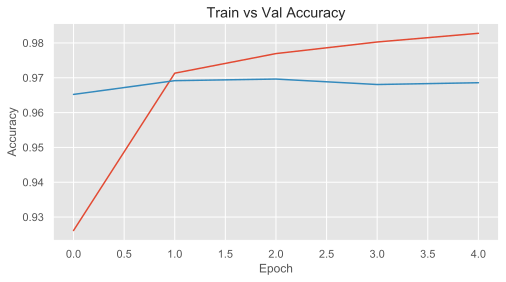

In [196]:
hist = pd.DataFrame(history.history)
plt.style.use("ggplot")
plt.figure(figsize=(8,4))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.title('Train vs Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Get Model Evaluations

In [197]:
test_pred = model.model.predict(X_te, verbose=1)

15503/15503 [==============================] - 10s 673us/step


In [198]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [199]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      tim       0.87      0.84      0.86      6518
      org       0.78      0.67      0.72      6487
      per       0.75      0.76      0.76      5430
      gpe       0.96      0.94      0.95      5231
      geo       0.85      0.90      0.87     12260
      art       0.21      0.15      0.18       119
      nat       0.69      0.18      0.29        60
      eve       0.46      0.22      0.30        99

micro avg       0.84      0.83      0.83     36204
macro avg       0.84      0.83      0.83     36204

